In [7]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
from latent_immunity_relative_fitness import RelativeFitnessDR, LatentRW, LatentSplineRW

In [8]:
import jax
from jax import jit, lax
from functools import partial
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evofr as ef

import matplotlib.dates as mdates

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA
from sklearn.manifold import MDS

In [9]:
#raw_seq = pd.read_csv("../../evofr/test/testing_data/mlr-variant-counts.tsv", sep="\t")
#raw_seq = raw_seq[raw_seq.location == "City0"]
#data = ef.VariantFrequencies(raw_seq, pivot="C")

In [10]:
#raw_seq = pd.read_csv("../../rt-from-frequency-dynamics/data/variants-us/variants-us_location-variant-sequence-counts.tsv", sep="\t")
#raw_seq
#data = ef.VariantFrequencies(raw_seq)
#data = ef.HierFrequencies(raw_seq, group="location")

In [11]:
#raw_seq = pd.read_csv("../../HHMI_poster/data/seq_counts_nextstrain_clades_usa.tsv.gz", sep="\t").rename(columns={"clade": "variant"})
#raw_seq = pd.read_csv("../../HHMI_poster/data/seq_counts_pango_lineages_usa.tsv.gz", sep="\t").rename(columns={"clade": "variant"})

raw_seq = pd.read_csv("../data/pango-lineage/collapsed-sequence-counts-global.tsv", sep="\t")
#TODO: Collapsing on pango data

In [12]:
date_start = "2023-03-01"
date_end = "2024-03-01"

raw_seq = raw_seq[raw_seq.date < date_end].copy()
raw_seq = raw_seq[raw_seq.date > date_start].copy()

data = ef.HierFrequencies(raw_seq, group="location")

In [13]:
unique_variants = raw_seq.variant.unique()
print(f"There are {len(unique_variants)} variants")
print(unique_variants)

unique_locations = raw_seq.location.unique()
print(f"There are {len(unique_locations)} locations")
print(unique_locations)

There are 41 variants
['B.1.1.529' 'BA.2.86.1' 'BA.5.2' 'BN.1' 'BQ.1.1' 'CH.1.1' 'CH.1.1.1'
 'EG.1' 'EG.5.1' 'EG.5.1.1' 'EG.5.1.3' 'EG.5.1.4' 'FL.1.5.1' 'FL.2' 'FL.4'
 'FU.1' 'GJ.1.2' 'GK.1.1' 'HF.1' 'HK.3' 'HV.1' 'JD.1.1' 'JG.3' 'JN.1'
 'JN.1.1' 'JN.1.4' 'XBB.1' 'XBB.1.16' 'XBB.1.16.1' 'XBB.1.16.11'
 'XBB.1.16.6' 'XBB.1.18.1' 'XBB.1.22.1' 'XBB.1.5' 'XBB.1.5.15'
 'XBB.1.5.70' 'XBB.1.9.1' 'XBB.1.9.2' 'XBB.2.3' 'XBB.2.3.11' 'other']
There are 14 locations
['Australia' 'Canada' 'Germany' 'Israel' 'Japan' 'South Korea' 'Spain'
 'USA' 'United Kingdom' 'Mexico' 'Brazil' 'Chile' 'France' 'China']


In [14]:
from evofr.plotting import FrequencyPlot, GrowthAdvantagePlot, TimeVaryingPlot, PatchLegend

In [15]:
phi_model = LatentSplineRW(ef.Spline(order=4, k=6))
latent_dim = 5
model = RelativeFitnessDR(dim=latent_dim, phi_model=phi_model, hier=True)
inference_method = ef.InferNUTS(num_samples=500, num_warmup=500)
inference_method = ef.InferMAP(lr=4e-4, iters=30_000)

posterior = inference_method.fit(model, data=data)

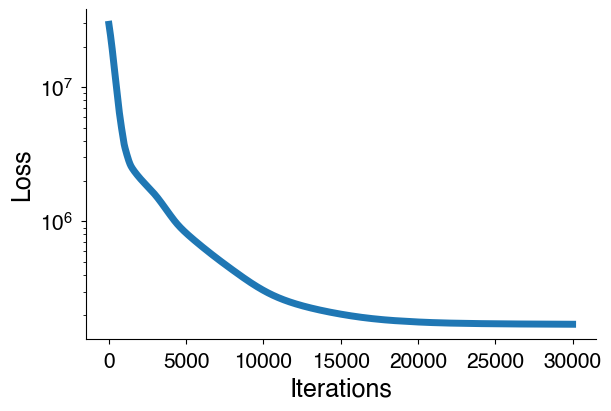

In [16]:
if "losses" in posterior.samples.keys():
    fig = plt.figure(figsize=(6., 4.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=1)
    ax = fig.add_subplot(spec[0])
    ax.plot(posterior.samples["losses"])
    ax.set_yscale("log")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Iterations")

In [17]:
def get_groups(samples, sites, group):
    samples_group = dict()
    for site in sites:
        samples_group[site] = samples[site][..., group] 
    return samples_group

def get_posterior(posterior, sites, group):
    _samples = get_groups(posterior.samples, sites, group)
    _data = posterior.data.groups[group]
    return ef.PosteriorHandler(samples=_samples, data=_data)

In [18]:
eta = posterior.samples["eta"][0,:,:]
eta_transformed = MDS(normalized_stress="auto").fit_transform(eta)

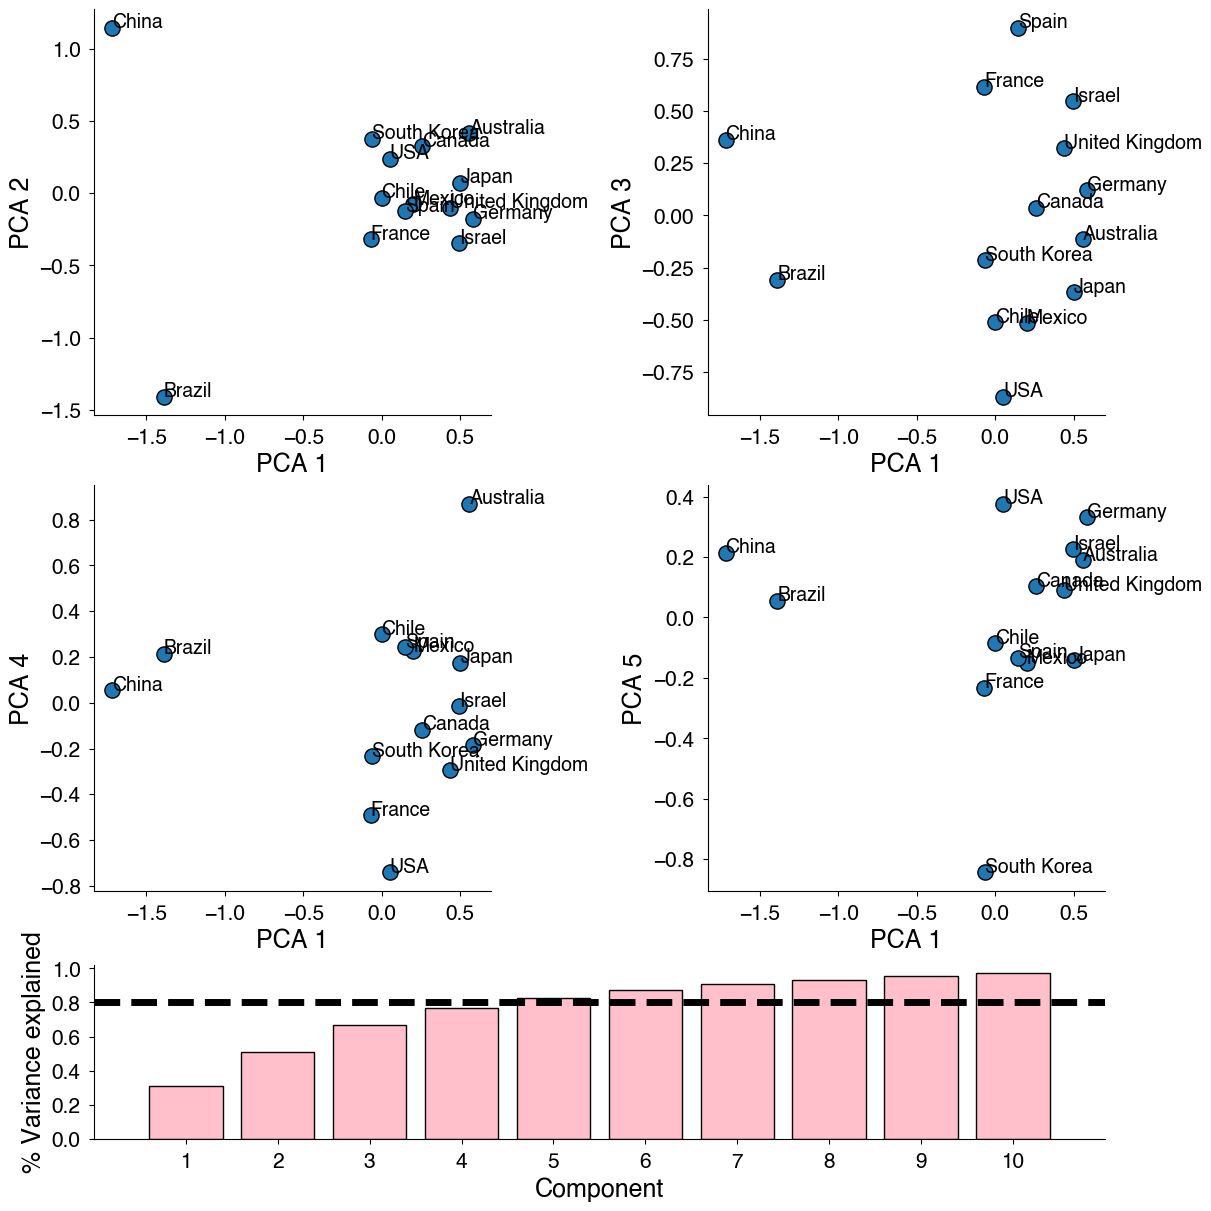

In [19]:

def plot_geo_phi_embedding(posterior):
    fig = plt.figure(figsize=(12., 12.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=2, nrows=3, height_ratios=[0.7, 0.7, 0.3])

    ax_explained = fig.add_subplot(spec[-2:])

    phi = posterior.samples["phi"][0, ...]
    
    # We want to collapse first three columns basically
    new_shape = (-1, phi.shape[-1])
    long_phi = np.reshape(phi, new_shape)
    
    pca = PCA(n_components=10)
    pca.fit(long_phi.T)
    
    # Plot locations
    phi_transformed = pca.transform(long_phi.T)
    def plot_pca_dims(ax, X_transformed, dim1, dim2):
        ax.scatter(X_transformed[:, dim1], X_transformed[:, dim2], ec="k", s=120)
        ax.set_xlabel(f"PCA {dim1+1}")
        ax.set_ylabel(f"PCA {dim2+1}")
        # Annotate
        for i, txt in enumerate(posterior.data.names):
            ax.annotate(txt, (X_transformed[i, dim1], X_transformed[i, dim2]), size=14, weight="bold")
        return None
    
    
    ax = fig.add_subplot(spec[0])
    plot_pca_dims(ax, phi_transformed, 0, 1)
    
    ax = fig.add_subplot(spec[1])
    plot_pca_dims(ax, phi_transformed, 0, 2)

    ax = fig.add_subplot(spec[2])
    plot_pca_dims(ax, phi_transformed, 0, 3)
    
    ax = fig.add_subplot(spec[3])
    plot_pca_dims(ax, phi_transformed, 0, 4)

    
    # Plot variance explained
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    ax_explained.bar(np.arange(var_explained.shape[0])+1, var_explained, ec="k", color="pink")
    ax_explained.set_xticks(np.arange(var_explained.shape[0])+1)
    ax_explained.set_xlabel("Component")
    ax_explained.set_ylabel("% Variance explained")
    ax_explained.set_xlim((0, 11))
    ax_explained.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax_explained.axhline(y=0.8, color="k", linestyle="--")
    return None
    
    
plot_geo_phi_embedding(posterior)

# TODO: Color by continent and show as supplementary figure
# Which are the most anamolous
# Are there "natural" clusters here? What are they?
# Are these well-explained by air travel?

(14, 10)


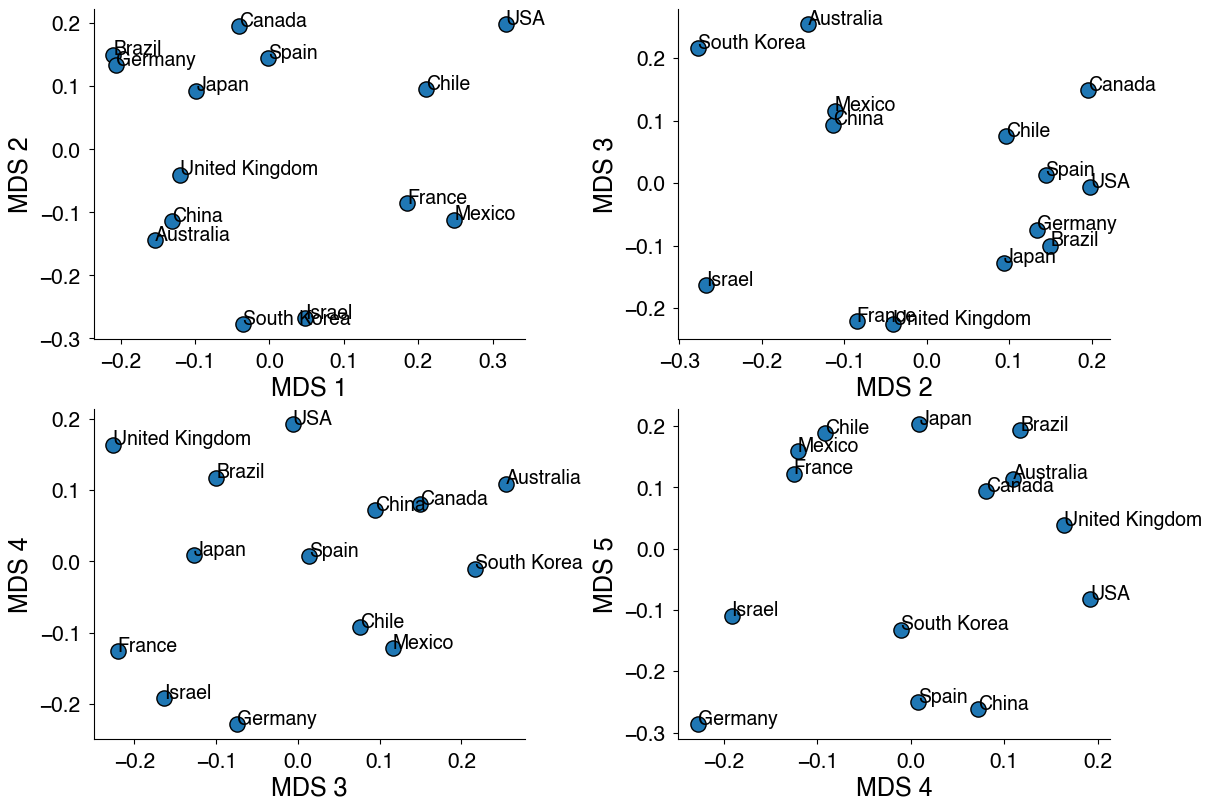

In [20]:
def plot_geo_phi_embedding(posterior):
    fig = plt.figure(figsize=(12., 8.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=2, nrows=2)
    phi = posterior.samples["phi"][0, ...]
    
    # We want to collapse first three columns basically
    new_shape = (-1, phi.shape[-1])
    long_phi = np.reshape(phi, new_shape)
    
    mds = MDS(10, normalized_stress=True, metric=False,random_state=12)
    phi_transformed = mds.fit_transform(long_phi.T)
    print(phi_transformed.shape)
    # Plot locations
    def plot_mds_dims(ax, X_transformed, dim1, dim2):
        ax.scatter(X_transformed[:, dim1], X_transformed[:, dim2], ec="k", s=120)
        ax.set_xlabel(f"MDS {dim1+1}")
        ax.set_ylabel(f"MDS {dim2+1}")
        # Annotate
        for i, txt in enumerate(posterior.data.names):
            ax.annotate(txt, (X_transformed[i, dim1], X_transformed[i, dim2]), size=14, weight="bold")
        return None
    
    
    ax = fig.add_subplot(spec[0])
    plot_mds_dims(ax, phi_transformed, 0, 1)
    ax = fig.add_subplot(spec[1])
    plot_mds_dims(ax, phi_transformed, 1, 2)
    ax = fig.add_subplot(spec[2])
    plot_mds_dims(ax, phi_transformed, 2, 3)
    ax = fig.add_subplot(spec[3])
    plot_mds_dims(ax, phi_transformed, 3, 4)

    return mds
    
    
mds = plot_geo_phi_embedding(posterior)

In [21]:
# Elbow plot on loss for increase latent_n 

# x-axis latent_n
# y-axis loss

In [22]:
antigenic_map = pd.concat([pd.read_csv("../data/antigenic_map_data/immunized human.csv"), 
                           pd.read_csv("../data/antigenic_map_data/naive human.csv")])

In [23]:
antigenic_map_melt = antigenic_map.melt(["id", "group"], var_name="strain", value_name="NT50")

In [24]:
def compute_log2_distances(X):
    X_transformed = np.log2(X.values)
    return np.sqrt(np.sum(np.square(X_transformed.T[..., None] - X_transformed), axis=1))

def create_titer_distance_df(X):
    rows = []
    for i, v in enumerate(X.columns):
        for j, u in enumerate(X.columns[:(i+1)]):
            rows.append({"variant_1": v, "variant_2": u, "titer_distance": distances[i, j]})
    return pd.DataFrame(rows)

X = antigenic_map.drop(columns=["id", "group"])
distances = compute_log2_distances(X)
distances_df = create_titer_distance_df(X)

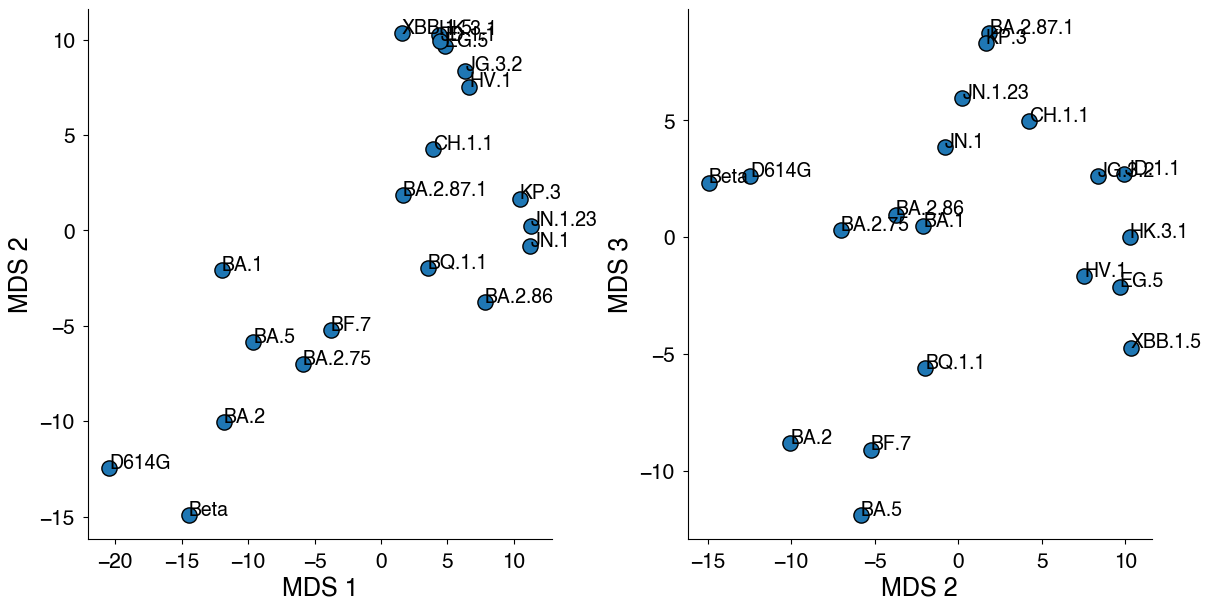

In [25]:
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1)

def plot_mds_dims(ax, X_transformed, dim1, dim2):
        ax.scatter(X_transformed[:, dim1], X_transformed[:, dim2], ec="k", s=120)
        ax.set_xlabel(f"MDS {dim1+1}")
        ax.set_ylabel(f"MDS {dim2+1}")
        # Annotate
        for i, txt in enumerate(X.columns):
            ax.annotate(txt, (X_transformed[i, dim1], X_transformed[i, dim2]), size=14, weight="bold")
        return None

mds = MDS(n_components=3, normalized_stress="auto", random_state=12)
X_transformed = mds.fit_transform(np.log2(X.values.T))

ax = fig.add_subplot(spec[0])
plot_mds_dims(ax, X_transformed, 0, 1 )
ax = fig.add_subplot(spec[1])
plot_mds_dims(ax, X_transformed, 1, 2)

In [26]:
common_variants = [v for v in posterior.data.var_names if v in X.columns]

Text(0, 0.5, 'log2 Human NT50 Titer Distance')

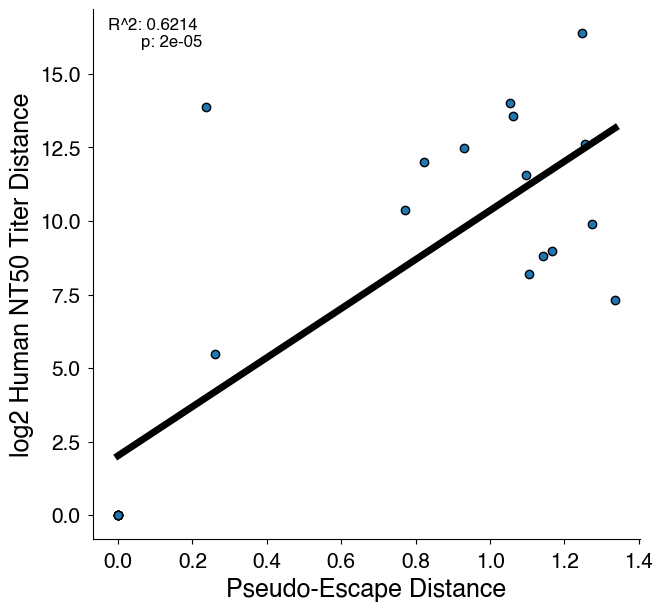

In [27]:
from scipy import stats

fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(1,2)
ax = fig.add_subplot(spec[0])

## Prepping data and labels
eta = posterior.samples["eta"][0, :-1, :] # Remove other
n_vars, n_comps = eta.shape

eta_distances = jnp.sqrt(jnp.sum(jnp.square(eta[..., None] - eta.T), axis=1))
var_names = posterior.data.var_names
var_to_index = {v: i for i, v in enumerate(var_names)}        

def add_latent_distance(row):
    if row["variant_1"] in common_variants and row["variant_2"] in common_variants:
        return float(eta_distances[var_to_index[row["variant_1"]], var_to_index[row["variant_2"]]])
    else:
        return np.nan
distances_df["latent_distance"] = distances_df.apply(add_latent_distance, axis=1)
    
# Fit linear regression
def fit_linear(col1, col2):
    x, y = distances_df[col1], distances_df[col2]
    is_finite = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[is_finite], y[is_finite]
    slope, intercept, r, p, se = stats.linregress(x, y)      
    xs = np.linspace(np.min(x), np.max(x), 20)
    ys = intercept + slope * xs
    return xs, ys, r, p

x_col, y_col =  "latent_distance", "titer_distance"
x, y = distances_df[x_col], distances_df[y_col]
ax.scatter(x, y, ec="k")       

# Fit linear regression between two variables
xs, ys, r, p = fit_linear(x_col, y_col)
ax.plot(xs, ys, color="k")

# Add regression statistics
ax.text(0.2, 0.985, f'R^2: {(r ** 2).round(4)} \np: {p.round(5)}',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
ax.set_xlabel("Pseudo-Escape Distance")
ax.set_ylabel("log2 Human NT50 Titer Distance")


In [87]:
clade_definitions = [
    {
        "clade": "24B",
        "display_name": "24B (JN.1.11.1)",
        "defining_lineage": "JN.1.11.1",
        "color": '#DC2F24'
    },
    {
        "clade": "24A",
        "display_name": "24A (JN.1)",
        "defining_lineage": "JN.1",
        "color": '#E4632E'
    },
    {
        "clade": "23I",
        "display_name": "23I (BA.2.86)",
        "defining_lineage": "BA.2.86",
        "color": '#E69136'
    },
    {
        "clade": "23H",
        "display_name": "23H (HK.3)",
        "defining_lineage": "HK.3",
        "color": '#D9AD3D'
    },
    {
        "clade": "23G",
        "display_name": "23G (XBB.1.5.70)",
        "defining_lineage": "XBB.1.5.70",
        "color": '#C1BA47'
    },
    {
        "clade": "23F",
        "display_name": "23F (EG.5.1)",
        "defining_lineage": "EG.5.1",
        "color": '#A2BE57'
    },
    {
        "clade": "23E",
        "display_name": "23E (XBB.2.3)",
        "defining_lineage": "XBB.2.3",
        "color": '#83BA70'
    },
    {
        "clade": "23D",
        "display_name": "23D (XBB.1.9)",
        "defining_lineage": "XBB.1.9",
        "color": '#69B091'
    },
    {
        "clade": "23C",
        "display_name": "23C (CH.1.1)",
        "defining_lineage": "CH.1.1",
        "color": '#549DB2'
    },
    {
        "clade": "23B",
        "display_name": "23B (XBB.1.16)",
        "defining_lineage": "XBB.1.16",
        "color": '#4580CA'
    },
    {
        "clade": "23A",
        "display_name": "23A (XBB.1.5)",
        "defining_lineage": "XBB.1.5",
        "color": '#462EB9'
    },
    {
        "clade": "22F",
        "display_name": "22F (XBB)",
        "defining_lineage": "XBB",
        "color": '#3E58CF'
    },
    {
        "clade": "22E",
        "display_name": "22E (BQ.1)",
        "defining_lineage": "BQ.1",
        "color": '#777777'
    },
    {
        "clade": "22D",
        "display_name": "22D (BA.2.75)",
        "defining_lineage": "BA.2.75",
        "color": '#777777'
    },
    {
        "clade": "22B",
        "display_name": "22B (BA.5)",
        "defining_lineage": "BA.5",
        "color": '#777777'
    },
    {
        "clade": "other",
        "display_name": "other",
        "defining_lineage": False,
        "color": '#777777'
    }
]

In [88]:
from pango_aliasor.aliasor import Aliasor
import colorsys

def order_lineages(lineages, aliasor):
    """
    Order input lineages by using their full uncompressed lineage & converting to a sortable form
    e.g. BA.5  -> B.1.1.529.5  -> '  B/001/001/529/005'
         BA.16 -> B.1.1.529.16 -> '  B/001/001/529/016'
         so BA.5 is before BA.16
    """
    def _lineage_sortable(lineage):
        if lineage=='other':
            return "ZZZ"
        lin_full = aliasor.uncompress(lineage)
        return "/".join([(f"{x:>3}" if i==0 else f"{int(x):03}") for i,x in enumerate(lin_full.split('.'))])
    return sorted(lineages,key=_lineage_sortable)

def order_lineages_within_clade(lineages, aliasor, clade_map):
    """
    Order input lineages by their clades first and then by using their full uncompressed lineage,
    converting to a sortable form within each clade.

    Parameters:
    lineages (list of str): List of lineage names to be sorted.
    aliasor (object): An object with a method `uncompress` that converts compressed lineage names to full lineage names.
    clades (list of str): List of clade assignments corresponding to each lineage.

    Returns:
    list of str: Sorted list of lineage names.

    Example:
    >>> class Aliasor:
    ...     def uncompress(self, lineage):
    ...         return {"BA.5": "B.1.1.529.5", "BA.16": "B.1.1.529.16", "BA.2": "B.1.1.529.2"}[lineage]
    >>> aliasor = Aliasor()
    >>> lineages = ["BA.5", "BA.16", "BA.2"]
    >>> clades = ["Clade1", "Clade1", "Clade2"]
    >>> order_lineages(lineages, aliasor, clades)
    ['BA.5', 'BA.16', 'BA.2']
    """

    def _lineage_sortable(lineage):
        if lineage == 'other':
            return "ZZZ"
        lin_full = aliasor.uncompress(lineage)
        return "/".join([(f"{x:>3}" if i == 0 else f"{int(x):03}") for i, x in enumerate(lin_full.split('.'))])
    
    # Sort the lineages first by clade and then by the sortable form of the lineage
    return sorted(lineages, key=lambda lineage: (clade_map[lineage], _lineage_sortable(lineage)))

def lineage_to_clade(lineage, aliasor, fallback, clade_definitions):
    lineage_full = aliasor.uncompress(lineage)
    for clade_data in clade_definitions:
        if clade_data['clade']=='other':
            continue
        comparison_lineage = aliasor.uncompress(clade_data['defining_lineage'])
        if lineage_full == comparison_lineage or lineage_full.startswith(comparison_lineage + "."):
            return clade_data['clade']
    return fallback

def clade_colors(variants, clade_definitions):
    colors = {c['clade']: c['color'] for c in clade_definitions}
    missing = set()
    defs = []
    for v in variants:
        try:
            defs.append([v, colors[v]])
        except KeyError:
            if v!='other':
                missing.add(v)
                defs.append([v, DEFAULT_CLADE_COLOR])

    # TODO: Emit this to output file so it can be sent thru Slack notifications
    if len(missing) > 0:
        print(
            f"Missing definitions for the following clades: {', '.join(missing)}.",
            f"They have been assigned the default color {DEFAULT_CLADE_COLOR!r}"
        )

    return defs

def clade_display_names(variants, clade_definitions):
    display_names = {c['clade']: c['display_name'] for c in clade_definitions}
    return [[name, display_names[name] if name in display_names else name]
            for name in variants]

def colour_range(anchor, n):
    """
    Create a range of `n` colours centred around the provided `anchor`.
    This currently involves simple manipulations in HLS space, but
    the outputs aren't going to be as good as they could be if we did it in
    a perceptually uniform space (e.g lab space). For the purposes of this viz
    I don't think it's a dealbreaker, and in our current setup it's hard to use
    python libraries which aren't already available in our various runtimes.
    """
    anchor_rgb = tuple(int(anchor.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    anchor_hls = colorsys.rgb_to_hls(*anchor_rgb)
    hrange = np.linspace(anchor_hls[0]*0.85, anchor_hls[0]*1.25, n)
    lrange = np.linspace(anchor_hls[1]*1.2, anchor_hls[1], n)
    srange = np.linspace(anchor_hls[2]*0.7, anchor_hls[2]*1.1, n)
    rgb_range = [colorsys.hls_to_rgb(*hls) for hls in zip(hrange, lrange, srange)]
    def clamp(x):
        return int(max(0, min(x, 255)))
    return [f"#{clamp(rgb[0]):02x}{clamp(rgb[1]):02x}{clamp(rgb[2]):02x}" for rgb in rgb_range]

def colourise(lineages, aliasor, clade_definitions):
    """
    Produces an array of arrays associating observed lineages with a colour hex. Example output:
        [
            ['XBB', '#ffffff'],
            ...
        ]
    """
    clades = {lineage: lineage_to_clade(lineage, aliasor, 'other', clade_definitions)
              for lineage in lineages}

    colours = []

    for clade in list(set(clades.values())):
        matching_lineages = [l for l in lineages if clades[l]==clade] # will be ordered
        print(f"{clade:<10}n={len(matching_lineages)} lineages")
        color_hex = [x['color'] for x in clade_definitions if x['clade']==clade][0]
        for pair in zip(matching_lineages, colour_range(color_hex, len(matching_lineages))):
            colours.append(pair)
    return colours

aliasor = Aliasor()
color_map = colourise(posterior.data.var_names, aliasor, clade_definitions)
color_map = {entry[0]: entry[1] for entry in color_map}
clade_map = {lineage: lineage_to_clade(lineage, aliasor, 'other', clade_definitions)
              for lineage in posterior.data.var_names}

23I       n=1 lineages
23C       n=2 lineages
22F       n=3 lineages
23A       n=3 lineages
23G       n=2 lineages
23F       n=6 lineages
other     n=2 lineages
22E       n=1 lineages
23B       n=6 lineages
23E       n=3 lineages
23H       n=1 lineages
22D       n=1 lineages
23D       n=6 lineages
22B       n=1 lineages
24A       n=3 lineages


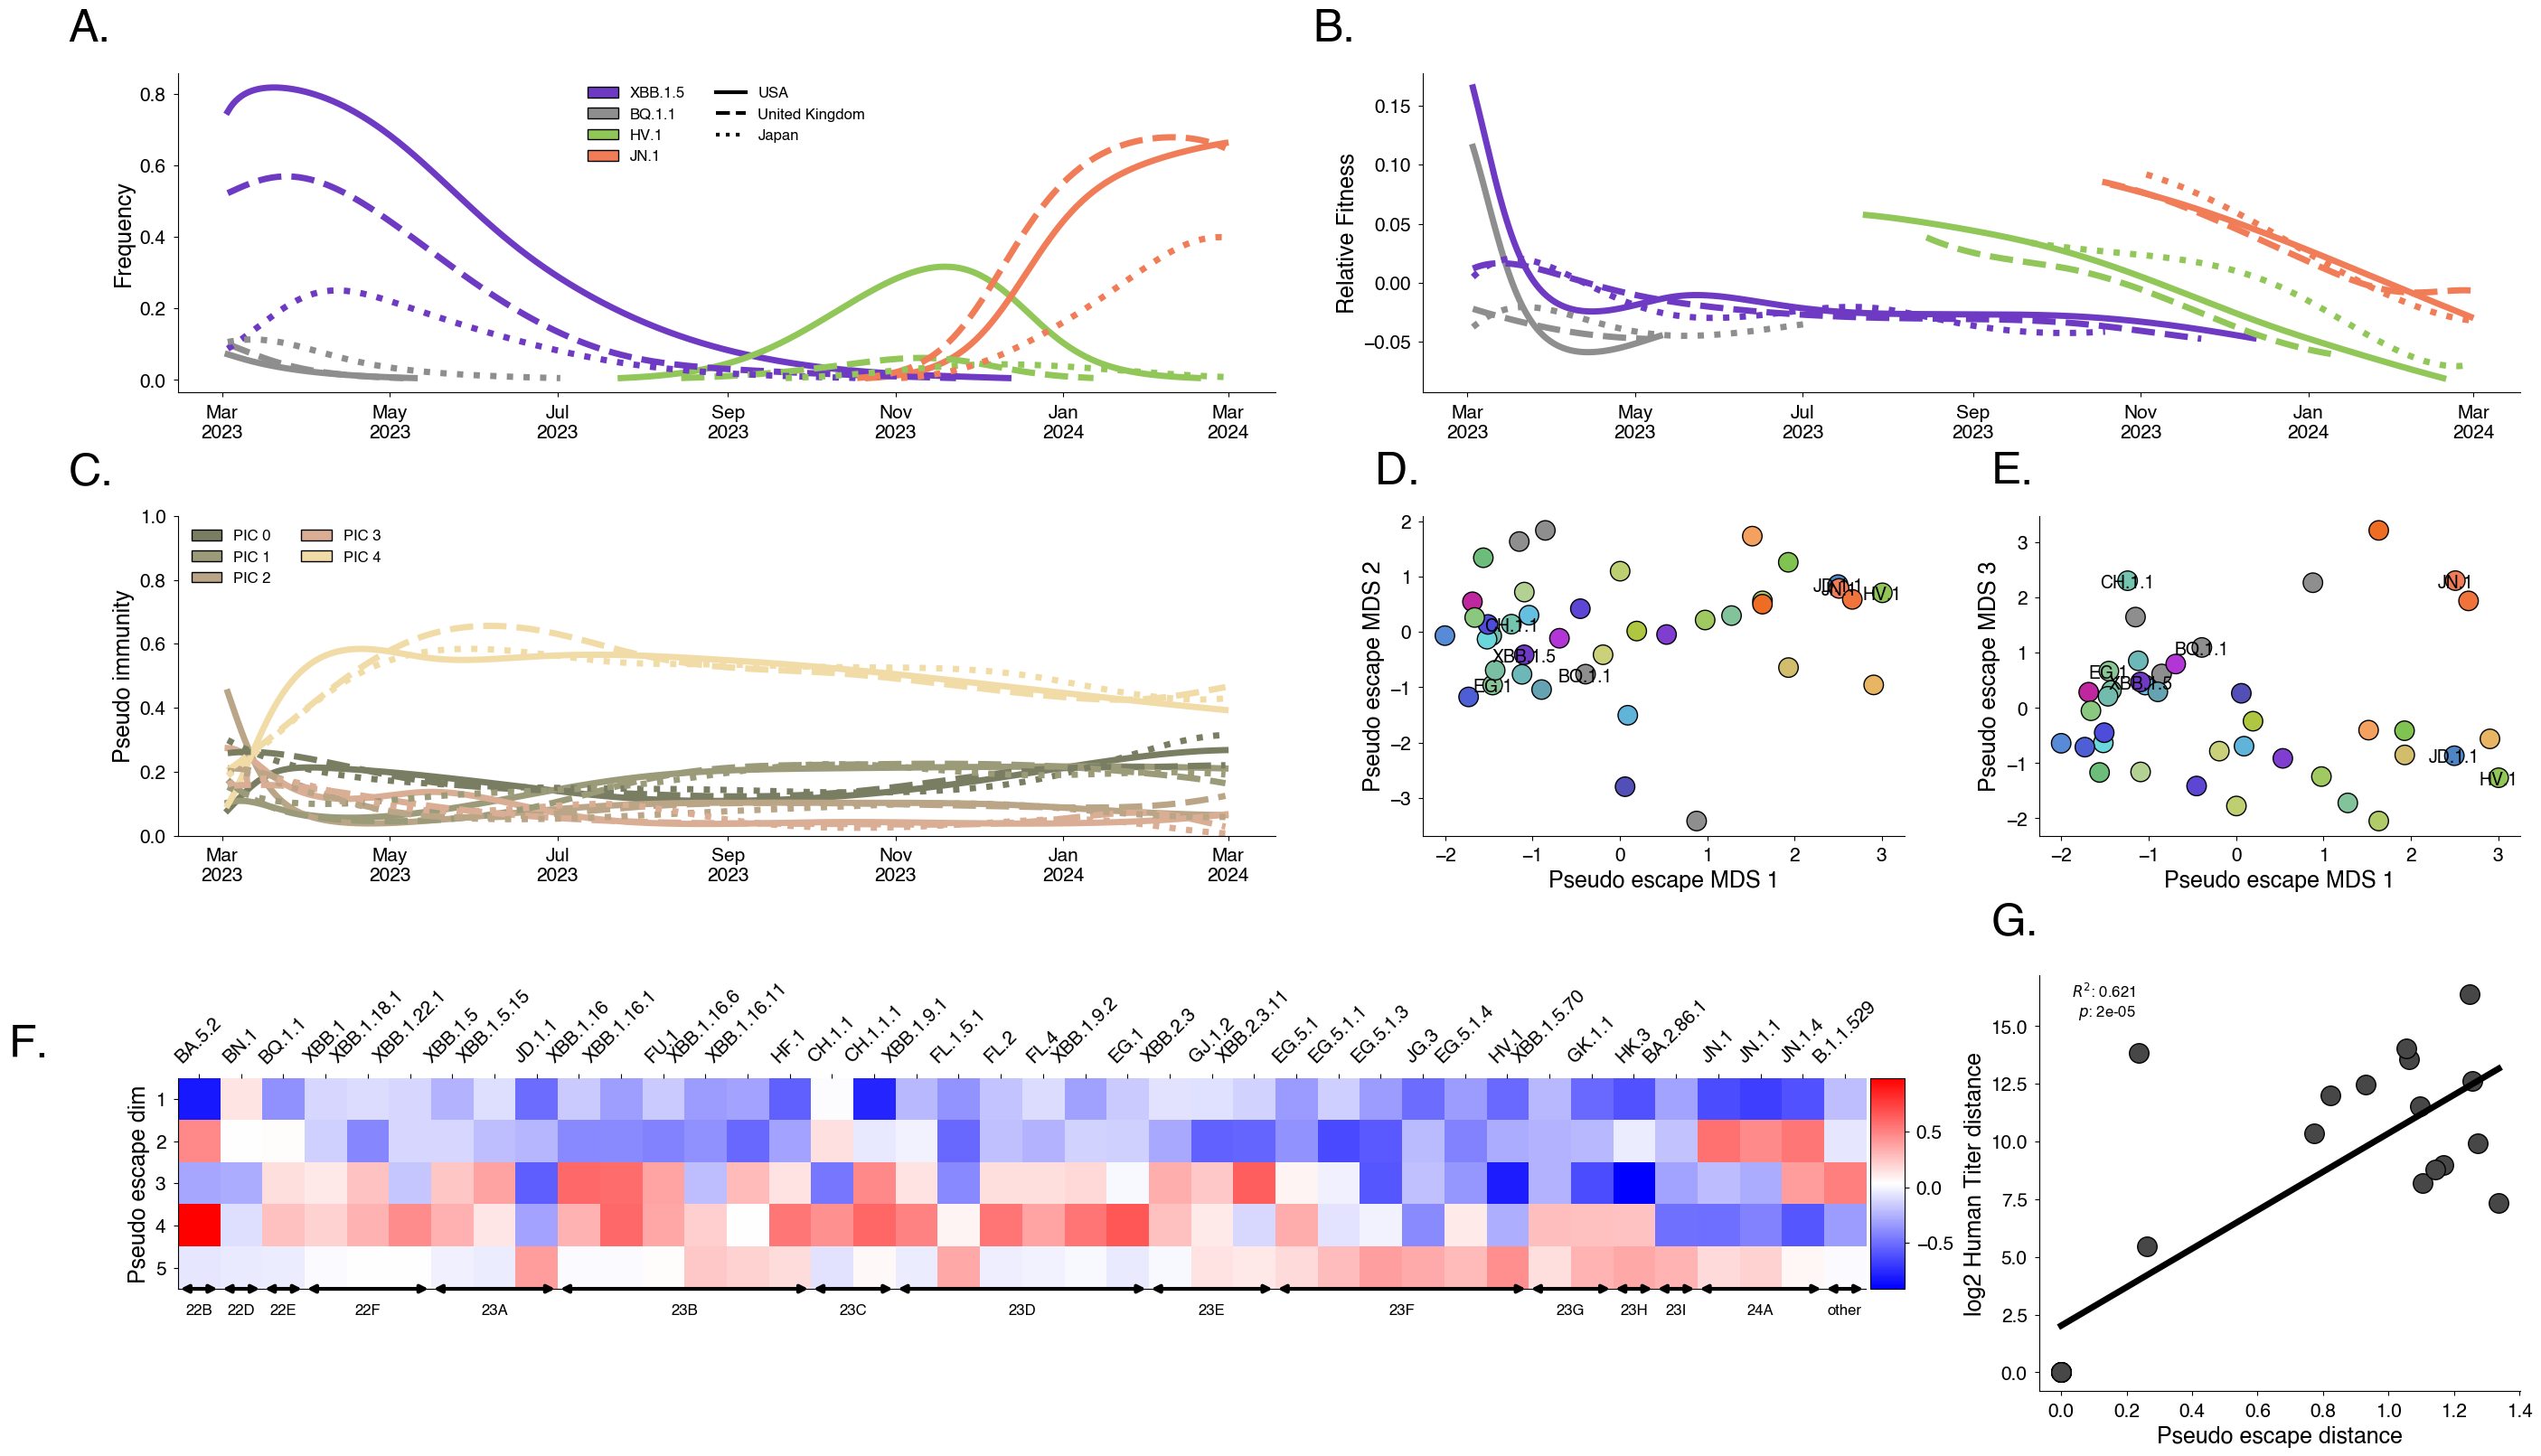

In [91]:
import matplotlib.dates as mdates

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_ordering(var_names):
    
    #reordered_names = order_lineages(var_names, aliasor)[:-1]
    reordered_names = order_lineages_within_clade(var_names, aliasor, clade_map)[:-1]
    reordered_clades = [clade_map[n] for n in reordered_names]

    reordered_idx = [var_names.index(r) for r in reordered_names]
    return reordered_idx, reordered_names, reordered_clades
    
# Fit linear regression
def fit_linear(col1, col2):
    x, y = distances_df[col1], distances_df[col2]
    is_finite = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[is_finite], y[is_finite]
    slope, intercept, r, p, se = stats.linregress(x, y)      
    xs = np.linspace(np.min(x), np.max(x), 20)
    ys = intercept + slope * xs
    return xs, ys, r, p

# Merge in latent distnances
def add_latent_distance(row, var_to_index):
    if row["variant_1"] in common_variants and row["variant_2"] in common_variants:
        return float(eta_distances[var_to_index[row["variant_1"]], var_to_index[row["variant_2"]]])
    else:
        return np.nan

def add_bracket(ax, start, end, label, y_offset=-0.1, height=0.02, **kwargs):
    """
    Add a bracket below the x-axis labels to group them.

    Parameters:
    ax : matplotlib.axes.Axes
        The axes to add the bracket to.
    start : int
        The starting index of the grouped labels.
    end : int
        The ending index of the grouped labels.
    label : str
        The label for the bracket.
    y_offset : float, optional
        The vertical offset for the bracket (default is -0.1).
    height : float, optional
        The height of the bracket (default is 0.02).
    kwargs : additional parameters for customization.
    """
    ax.annotate('', xy=(start, y_offset), xytext=(end, y_offset),
                arrowprops=dict(arrowstyle='<|-|>', lw=3.0, **kwargs))
    ax.text((start + end) * 0.5, y_offset - height, label,
            ha='center', va='center', **kwargs)
    
def add_clade_dividers(ax, reordered_clades, height=-0.4, y_offset=4.5):
    current_clade = reordered_clades[0]
    start = 0

    for i in range(1, len(reordered_clades)):
        if reordered_clades[i] != current_clade:
            add_bracket(ax, start-0.5, i-0.5, current_clade, y_offset=y_offset, height=height)
            current_clade = reordered_clades[i]
            start = i
            
    # Add bracket for the last group
    add_bracket(ax, start - 0.5, len(reordered_clades)-1 + 0.5, current_clade, y_offset=y_offset, height=height)
        
def summary_plot_hier(posterior, color_map,
                      label_variants=None, 
                      focal_variants=None,
                      focal_locations=None,
                      freq_thres = None,
                      plot_eta_time_mean=True):
    fig = plt.figure(figsize=(28., 16.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=4, nrows=3, height_ratios=[1.0, 1.0, 1.3])
    axes = []

    # Prep variants to plot in panels <A-B>
    if focal_variants is None:
        focal_variants = ["HK.3", "JN.1", "JN.1.1"]
    var_names = posterior.data.var_names
    var_idxs = [var_names.index(v) if v in var_names else None for v in focal_variants]
    
    # Prep locations to plot in panel <A-B-C>
    if focal_locations is None:
        focal_locations = ["USA", "United Kingdom", "Japan"]
    loc_names = posterior.data.names
    loc_idxs = [loc_names.index(loc) if loc in loc_names else None for loc in focal_locations]
    focal_style = {loc: ["-", "--", ":"][l] for l, loc in enumerate(focal_locations)}
    
    # Prep colors for immunity components in panel <C>
    immunity_colors = ["#f8f9fa","#e9ecef","#dee2e6","#ced4da","#adb5bd","#6c757d","#495057","#343a40","#212529"]
    immunity_colors = ["#797d62","#9b9b7a","#baa587","#d9ae94","#f1dca7","#ffcb69","#e8ac65","#d08c60","#b58463","#997b66"]
    num_pseudo_immune = posterior.samples["phi"].shape[2]
    pic_color_map = {n: immunity_colors[n] for n in range(num_pseudo_immune)}
    
    # Prep locations to annoate in panel E
    if label_variants is None:
        label_variants = ["XBB.1.5", "EG.1", "HK.3", "JN.1", "JN.1.1"]

    # Get ordering and clades with pango_aliasor
    reordered_idx, reordered_names, reordered_clades = get_ordering(var_names)
    
    # Only plot variant at times above `freq_thres`
    if freq_thres is None:
        freq_thres = 0.001

    # Frequency
    ax = fig.add_subplot(spec[0, 0:2])
    for loc_idx, location in zip(loc_idxs, focal_locations):
        for var_idx, variant in zip(var_idxs, focal_variants):
            included = np.array((posterior.samples["freq"][0, :, var_idx, loc_idx] > freq_thres))
            ax.plot(np.array(posterior.data.dates)[included], posterior.samples["freq"][0, :, var_idx, loc_idx][included], color=color_map[variant], linestyle=focal_style[location])
    ax.set_ylabel("Frequency")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)
        
    # Add legend for focal variants
    variant_color_elements =  [Patch(facecolor=color_map[v], edgecolor='k', label=v) for v in focal_variants]
    location_style_elements = [Line2D([0], [0], color='k', lw=3, linestyle=focal_style[l], label=l) for l in focal_locations]
    legend_elements = variant_color_elements + location_style_elements
    ax.legend(handles=legend_elements, loc='best', ncols=2, frameon=False)

    # Relative Fitness
    ax = fig.add_subplot(spec[0, 2:4], sharex=ax)
    for loc_idx, location in zip(loc_idxs, focal_locations):
        for var_idx, variant in zip(var_idxs, focal_variants):
            included = np.array((posterior.samples["freq"][0, :, var_idx, loc_idx] > freq_thres))
            ax.plot(np.array(posterior.data.dates)[included], posterior.samples["delta"][0, :, var_idx, loc_idx][included], color=color_map[variant], linestyle=focal_style[location])
    ax.set_ylabel("Relative Fitness")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)
 

    # Phi 
    ax = fig.add_subplot(spec[1, 0:2])
    for loc_idx, location in zip(loc_idxs, focal_locations):
        for pic in range(num_pseudo_immune):
            ax.plot(posterior.data.dates, posterior.samples["phi"][0, :, pic, loc_idx], color=pic_color_map[pic], linestyle=focal_style[location])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax.set_ylabel("Pseudo immunity")
    ax.set_ylim(0,1)

    # Add legend for PICs
    pic_color_elements =  [Patch(facecolor=pic_color_map[pic], edgecolor='k', label=f"PIC {pic}") for pic in range(num_pseudo_immune)]
    ax.legend(handles=pic_color_elements, loc='upper left', ncols=2, frameon=False)

    axes.append(ax)
    
    # Eta
    ## Prepping data and labels
    eta = posterior.samples["eta"][0, :-1, :] # Remove other
    n_vars, n_comps = eta.shape
    eta_reordered = eta.T[:, np.array(reordered_idx).astype(int)]
    xticklabels_reordered = [posterior.data.var_names[:-1][r] for r in reordered_idx]
    
    # Plotting matrix of values
    ax = fig.add_subplot(spec[2, :3])
    im = ax.matshow(eta_reordered, cmap="bwr")
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_xticks(np.arange(n_vars))
    ax.set_xticklabels(xticklabels_reordered, rotation=45)
    ax.tick_params(axis='x', bottom=False)

    ax.set_yticks(np.arange(n_comps))
    ax.set_yticklabels(np.arange(1, n_comps + 1))
    ax.set_ylabel("Pseudo escape dim")
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')    
    axes.append(ax)
    
    ## Adding clade dividers
    add_clade_dividers(ax, reordered_clades, height=-0.5, y_offset=n_comps-0.5)

    # Plotting embedding variant space
    mds = MDS(n_components=3, normalized_stress="auto", random_state=12)
    eta_scaled = (eta - eta.mean(axis=0)) / np.std(eta, axis=0)
    eta_transformed = mds.fit_transform(eta_scaled)
    
    def _plot_mds_escape(ax, dim_1, dim_2, plot_time_mean=True):
        ax.scatter(eta_transformed[:,dim_1], eta_transformed[:,dim_2], 
                   ec="k", 
                   color=[color_map[v] for v in posterior.data.var_names[:-1]],
                   s=240)
        ax.set_xlabel(f"Pseudo escape MDS {dim_1+1}")
        ax.set_ylabel(f"Pseudo escape MDS {dim_2+1}")   
        
        if plot_time_mean:
            for loc_idx, location in zip(loc_idxs, focal_locations):
                freq = posterior.samples["freq"][0, :, :-1, loc_idx]
                eta_transformed_time = (freq @ eta_transformed) # Average over variants
                ax.plot(eta_transformed_time[:,dim_1], eta_transformed_time[:,dim_2], color="k", linestyle=focal_style[location], lw=4)
        
        # Add names to variants
        for i, txt in enumerate(posterior.data.var_names[:-1]):
            if txt in label_variants + focal_variants:
                ax.annotate(txt, (eta_transformed[i,dim_1], eta_transformed[i,dim_2]), rotation=0, size=14, weight="bold", ha='center', va="center_baseline")
        return None
    
    ax = fig.add_subplot(spec[1,2])    
    _plot_mds_escape(ax, 0, 1, plot_eta_time_mean)
    axes.append(ax)

    ax = fig.add_subplot(spec[1,3])
    _plot_mds_escape(ax, 0, 2, plot_eta_time_mean)
    axes.append(ax)
    
    # Add human titer comparison
    ax = fig.add_subplot(spec[2,3])
    eta_distances = jnp.sqrt(jnp.sum(jnp.square(eta[..., None] - eta.T), axis=1))
    var_to_index = {v: i for i, v in enumerate(var_names)}        
    distances_df["latent_distance"] = distances_df.apply(lambda x: add_latent_distance(x, var_to_index), axis=1)

    x_col, y_col =  "latent_distance", "titer_distance"
    x, y = distances_df[x_col], distances_df[y_col]
    ax.scatter(x, y, ec="k", color="#474747", s=240)      

    # Fit linear regression between two variables
    xs, ys, r, p = fit_linear(x_col, y_col)
    ax.plot(xs, ys, color="k")

    # Add regression statistics
    stats_text = r'$R^2$: ' + str((r ** 2).round(3)) +"\n" r"$p$: " + str(p.round(5))

    ax.text(0.2, 0.985, stats_text,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes)
    ax.set_xlabel("Pseudo escape distance")
    ax.set_ylabel("log2 Human Titer distance")
    axes.append(ax)

    # Add labels
    ax_labels = ["A", "B", "C", "F", "D", "E", "G"] 

    for ax, ax_label in zip(axes, ax_labels):
        ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')
    return fig

fig = summary_plot_hier(posterior, color_map, freq_thres=0.005, 
                        focal_variants=["XBB.1.5", "BQ.1.1", "HV.1", "JN.1"],
                        label_variants=["XBB.1.5", "CH.1.1", "BQ.1.1", "JD.1.1", "EG.1", "HV.1", "JN.1"],
                        plot_eta_time_mean=False
                       )
fig.savefig("../manuscript/figures/" + "latent_immune.png")

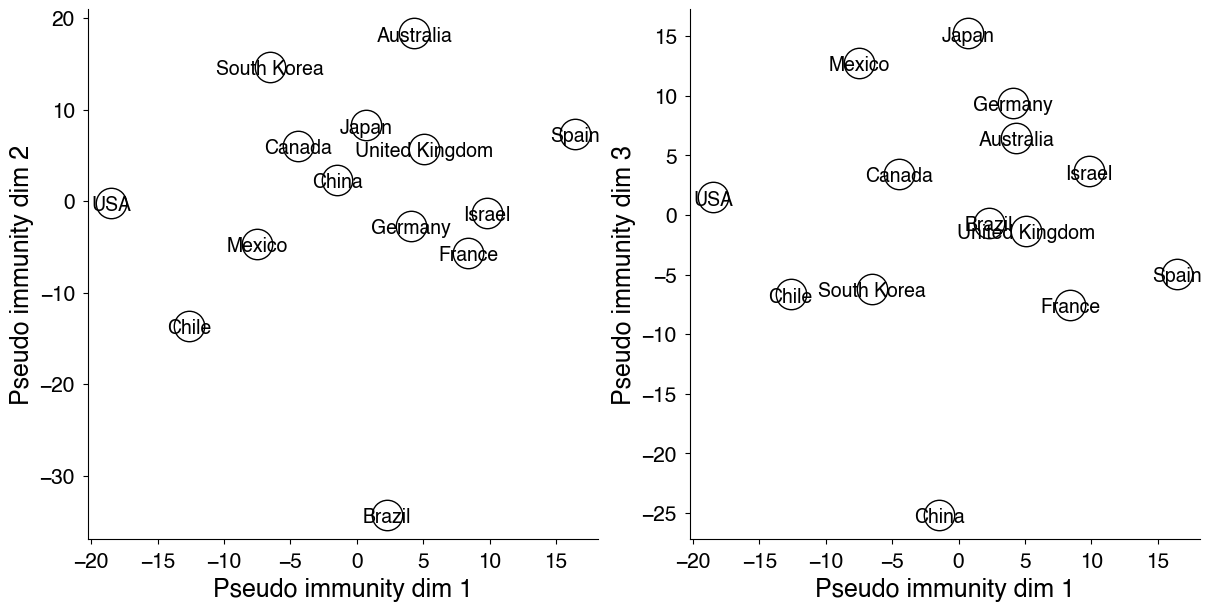

In [92]:
# Embed by location
phi = posterior.samples["phi"][0, :, :-1, :] # Remove other
phi_scaled = (phi - phi.mean(axis=0)) / np.std(phi, axis=0)
phi_scaled = jnp.reshape(phi_scaled, (-1, len(posterior.data.names)) )
phi_transformed = mds.fit_transform(phi_scaled.T)
    
def _plot_mds_location(ax, dim_1, dim_2):
    ax.scatter(phi_transformed[:,dim_1], phi_transformed[:,dim_2], 
                   ec="k", 
                   color="white",
                   s=480)
    ax.set_xlabel(f"Pseudo immunity dim {dim_1+1}")
    ax.set_ylabel(f"Pseudo immunity dim {dim_2+1}")   
                
    # Add names to locations
    for i, txt in enumerate(posterior.data.names):
        ax.annotate(txt, (phi_transformed[i,dim_1], phi_transformed[i,dim_2]), rotation=0, size=14, weight="bold", ha='center', va="center_baseline")
    return None
    
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1)

ax = fig.add_subplot(spec[0])
_plot_mds_location(ax, 0, 1)

ax = fig.add_subplot(spec[1])
_plot_mds_location(ax, 0, 2)

In [93]:
def create_titer_distance_df(X):
    rows = []
    for i, v in enumerate(X.columns):
        for j, u in enumerate(X.columns[:(i+1)]):
            rows.append({"variant_1": v, "variant_2": u, "titer_distance": distances[i, j]})
    return pd.DataFrame(rows)

distances_dfs = []
for name, group in antigenic_map.groupby("group"):
    X = group.drop(columns=["id", "group"])
    distances = compute_log2_distances(X)
    _distance_df = create_titer_distance_df(X)
    _distance_df["group"] = name
    distances_dfs.append(_distance_df)

distances_dfs = pd.concat(distances_dfs)

In [94]:
distances_dfs

,variant_1,variant_2,titer_distance,group
0,D614G,D614G,0.000000,BA.5 BTI
1,Beta,D614G,2.660460,BA.5 BTI
2,Beta,Beta,0.000000,BA.5 BTI
3,BA.1,D614G,11.123402,BA.5 BTI
4,BA.1,Beta,11.188021,BA.5 BTI
...,...,...,...,...
205,KP.3,BA.2.86,0.201634,XBB infection
206,KP.3,JN.1,0.000000,XBB infection
207,KP.3,BA.2.87.1,0.722466,XBB infection
208,KP.3,JN.1.23,0.000000,XBB infection


In [95]:
len(distances_dfs.group.unique())

7

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_27996/904527701.py:59: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


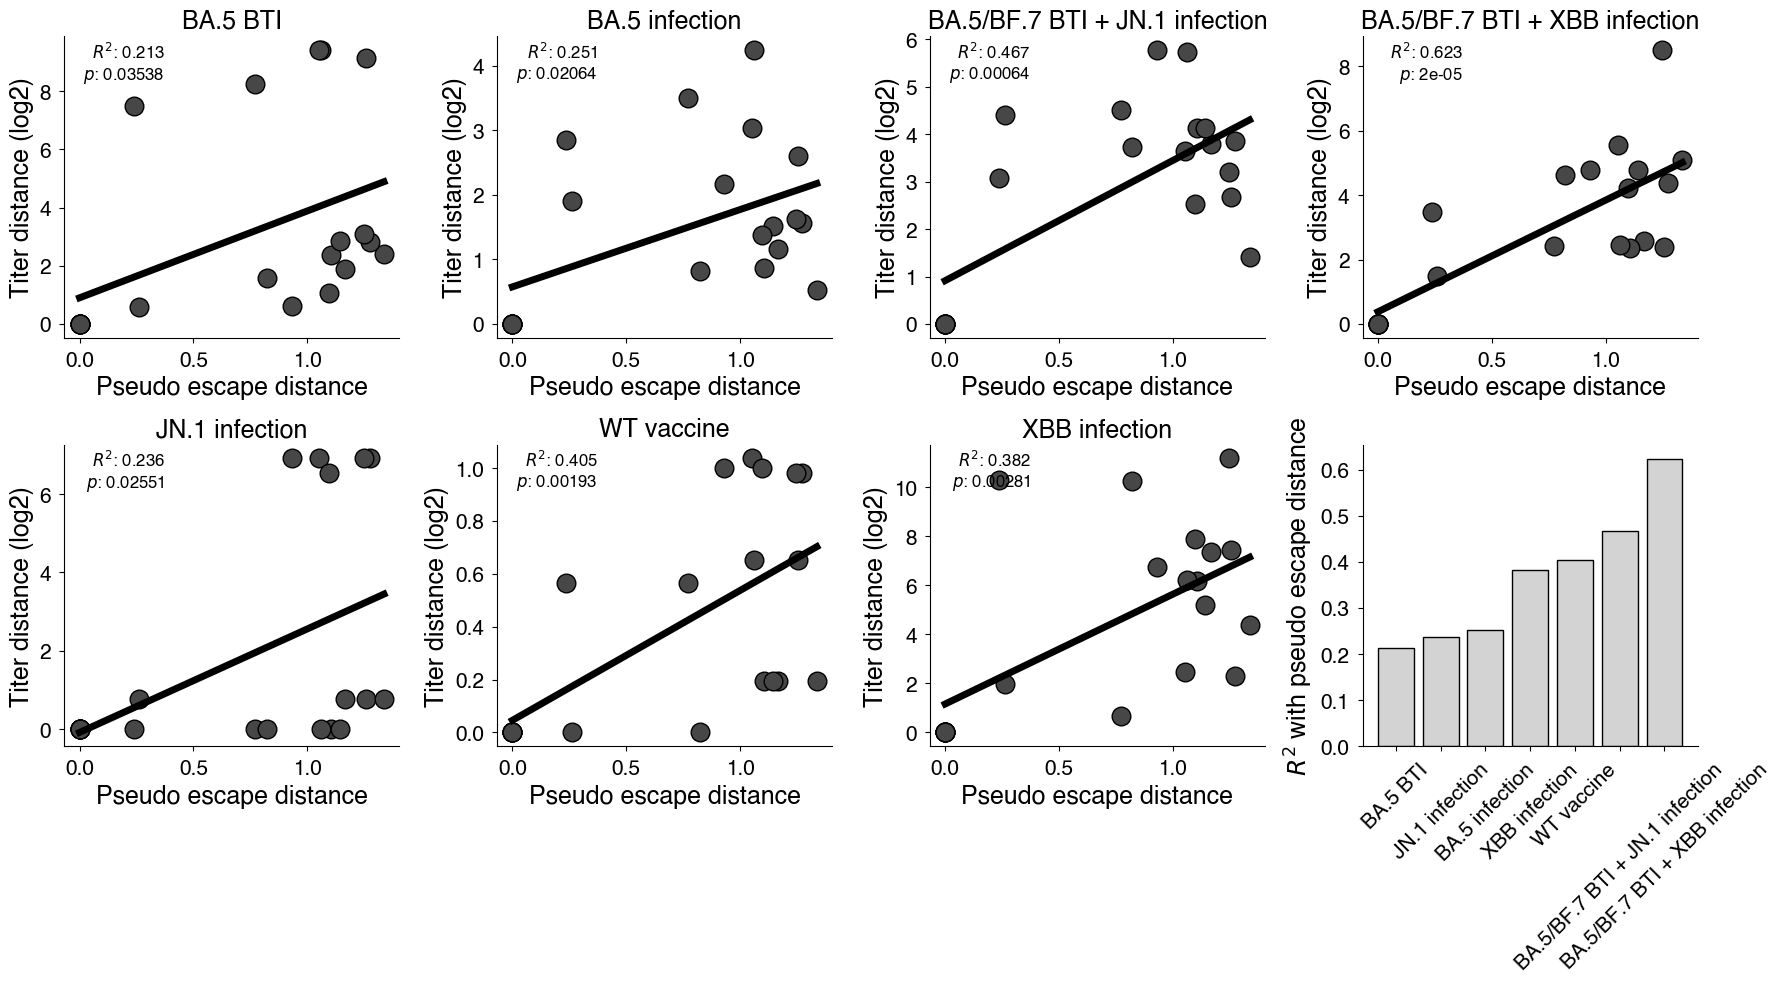

In [99]:
fig = plt.figure(figsize=(18., 10.), constrained_layout=True)
spec = fig.add_gridspec(2,4)

## Prepping data and labels
eta = posterior.samples["eta"][0, :-1, :] # Remove other
n_vars, n_comps = eta.shape

eta_distances = jnp.sqrt(jnp.sum(jnp.square(eta[..., None] - eta.T), axis=1))
var_names = posterior.data.var_names
var_to_index = {v: i for i, v in enumerate(var_names)}        

def add_latent_distance(row):
    if row["variant_1"] in common_variants and row["variant_2"] in common_variants:
        return float(eta_distances[var_to_index[row["variant_1"]], var_to_index[row["variant_2"]]])
    else:
        return np.nan
distances_dfs["latent_distance"] = distances_dfs.apply(add_latent_distance, axis=1)
    
# Fit linear regression
def fit_linear(df, col1, col2):
    x, y = df[col1], df[col2]
    is_finite = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[is_finite], y[is_finite]
    slope, intercept, r, p, se = stats.linregress(x, y)      
    xs = np.linspace(np.min(x), np.max(x), 20)
    ys = intercept + slope * xs
    return xs, ys, r, p

correlation_df = []
for i, (name, group) in enumerate(distances_dfs.groupby("group")):
    ax = fig.add_subplot(spec[i])
    x_col, y_col =  "latent_distance", "titer_distance"
    x, y = group[x_col], group[y_col]
    ax.scatter(x, y, ec="k", color="#474747", s=180)            

    # Fit linear regression between two variables
    xs, ys, r, p = fit_linear(group, x_col, y_col)
    ax.plot(xs, ys, color="k")

    # Add regression statistics
    stats_text = r'$R^2$: ' + str((r ** 2).round(3)) +"\n" r"$p$: " + str(p.round(5))
    ax.text(0.3, 0.985, stats_text,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes)
    ax.set_xlabel("Pseudo escape distance")
    ax.set_ylabel("Titer distance (log2)")
    ax.set_title(name)
    
    correlation_df.append({"group": name, "R2": r ** 2})
    
correlation_df = pd.DataFrame(correlation_df).sort_values(by="R2")

ax = fig.add_subplot(spec[-1])
ax.bar(correlation_df.group, correlation_df.R2, ec="k", color="lightgrey")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel(r"$R^2$ with pseudo escape distance")
fig.tight_layout()

fig.savefig("../manuscript/supplementary_figures/titer_pseudo_escape_distance_by_group.png")